# Task Description

https://www.kaggle.com/c/titanic/overview

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

# Initial Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Exploratory Data Analysis

In [3]:
df = pd.read_csv('dataset\\train.csv', encoding='utf-8', index_col='PassengerId')
df_copy = df.copy()
print(f'Table size: {df.shape}.')
print('First 5 lines:')
display(df.head(5))
print('Last 5 lines:')
display(df.tail(5))

Table size: (891, 11).
First 5 lines:


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Last 5 lines:


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Feature types:
1. Survived (target variable) - binary categorical (0 = no, 1 = yes),
2. Pclass (passenger class) - ordinal categorical (1st < 2nd < 3rd),
3. Sex - binary categorical (male, female),
4. Age - numerical continuous,
5. SibSp (number of siblings and spouses aboard) - numerical discrete,
6. Parch (number of parents and children aboard) - numerical discrete,
7. Ticket (ticket number) - nominal categorical,
8. Fare (ticket price) - numerical continuous,
9. Cabin - nominal categorical,
10. Embarked (port of embarkation) - nominal categorical (C = Cherbourg, Q = Queenstown, S = Southampton).

In [5]:
(df['Survived'].value_counts(normalize=True)).apply(lambda x: round(x, 2))

Survived
0    0.62
1    0.38
Name: proportion, dtype: float64

38% of passengers survived, whereas 62% passengers died. Classes are imbalanced.

In [6]:
(df.groupby('Sex')['Survived'].value_counts(normalize=True)).apply(lambda x: round(x,2))

Sex     Survived
female  1           0.74
        0           0.26
male    0           0.81
        1           0.19
Name: proportion, dtype: float64

74% of women survived while 26% died compared to 19 and 81% of men, respectively.

In [7]:
df.groupby('Pclass')['Name'].count()

Pclass
1    216
2    184
3    491
Name: Name, dtype: int64

216 passengers were travelling in the 1st class, 184 - in the 2nd class, 491 - in the 3rd.

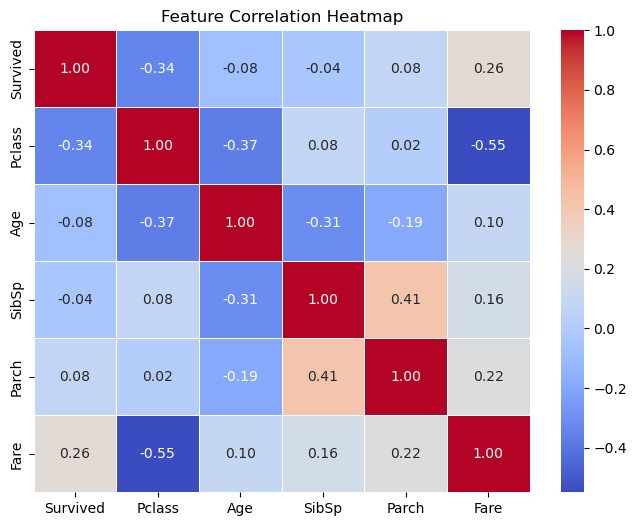

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True),
            annot=True,   
            fmt=".2f",
            cmap="coolwarm",
            linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

There is a moderate correlation between some features:

1. Pclass and Fare (-0.55)
2. SibSp and Parch (+0.41)
3. Pclass and Age (-0.37)
4. SibSp and Age (-0.31)
5. Pclass and Survival (-0.34)
6. Fare and Survival (+0.26)

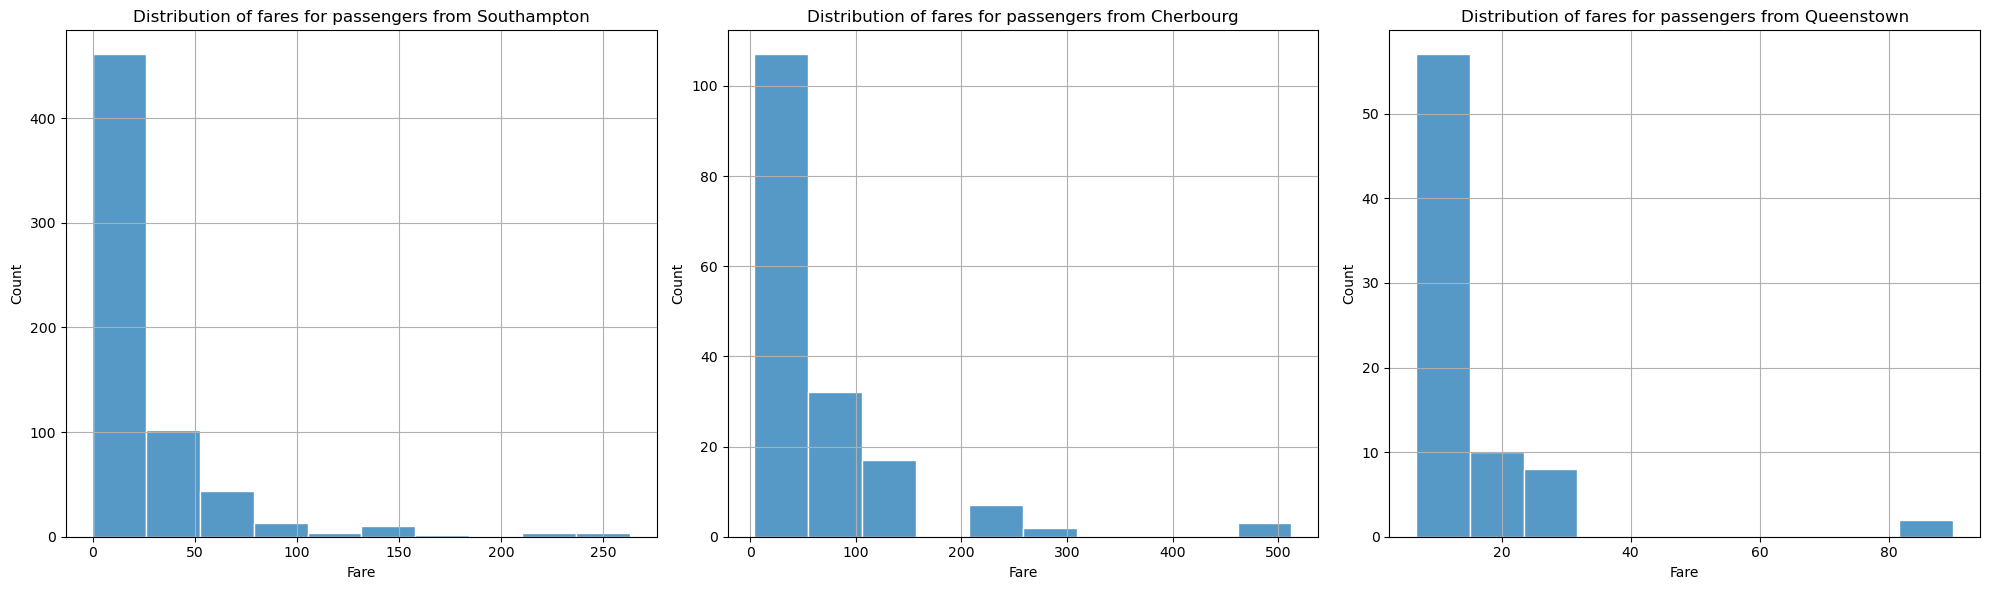

In [9]:
cities = {'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'}
ncols = len(df[df['Embarked'].notna()]['Embarked'].unique())
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 6))

for i in range(ncols):
    sns.histplot(data=df[(df['Embarked'] == df[df['Embarked'].notna()]['Embarked'].unique()[i]) & (df['Embarked'].notna())]['Fare'].values, fill=True, ax=axes[i], edgecolor='white', bins=10)
    
    axes[i].set_title(f'Distribution of fares for passengers from {cities[df['Embarked'].unique()[i]]}')
    axes[i].set_xlabel('Fare')
    axes[i].set_ylabel('Count')
    axes[i].grid(True)
    
plt.tight_layout()
plt.show()

Based on the graphs, we can say that most passengers bought cheap tickets (the cheaper - the more purchases).

The most expensive tickets were sold in Cherbourg (just above 510) followed by Southampton (about 260) and Queenstown (approx 90).

The total number of tickets sold is the highest in Southampton followed by Cherbourg and Queenstown.

The average fare was the highest in Cherbourg (about 60), while Southampton (approx 27) and Queenstown (approx 13) were on the 2nd and 3rd position, respectively (see graph below).

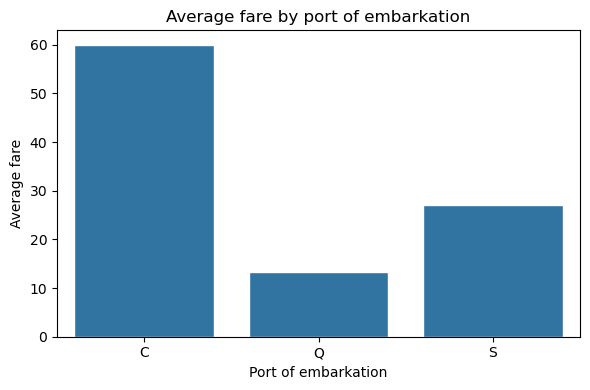

In [10]:
plt.figure(figsize=(6,4))
graph = sns.barplot(data=df.groupby('Embarked')['Fare'].mean(), edgecolor='white')
graph.set_title('Average fare by port of embarkation')
graph.set(xlabel="Port of embarkation", ylabel="Average fare")
plt.tight_layout()
plt.show();

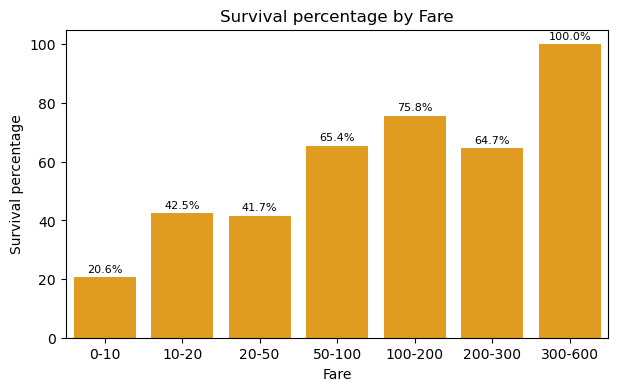

In [11]:
# Defining bins for Fare
bins = [0, 10, 20, 50, 100, 200, 300, 600]
df_fare_bins = df.copy()
df_fare_bins['Fare_bin'] = pd.cut(df['Fare'], bins=bins, labels=[f"{b}-{bins[i+1]}" for i, b in enumerate(bins[:-1])])

# Computing survival rate per Fare bin
fare_survival = df_fare_bins.groupby("Fare_bin")["Survived"].mean().reset_index()
fare_survival["Survived"] *= 100

fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(data=fare_survival, x="Fare_bin", y="Survived", color='orange', ax=ax)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

plt.ylabel("Survival percentage")
plt.xlabel("Fare")
plt.title("Survival percentage by Fare")
plt.show();

As we can see, the survival percentage steadily grows from 20.6% percent to 100% depending on the ticket price. 
That means, passengers with more expensive tickets indeed survived on average more often.

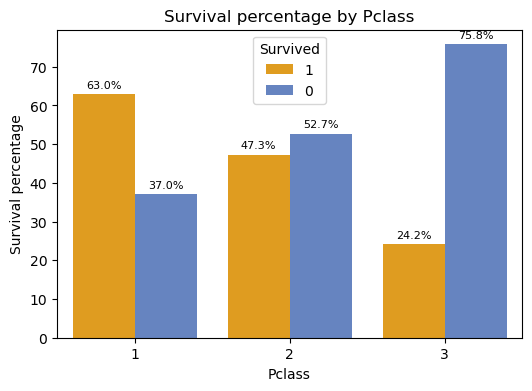

In [12]:
df_grouped = (df.groupby("Pclass")["Survived"].value_counts(normalize=True) * 100).rename("Percentage").reset_index()

fig, ax = plt.subplots(figsize=(6, 4))
graph = sns.barplot(data=df_grouped, x="Pclass", y="Percentage", hue="Survived", hue_order=[1,0], palette=['orange', '#577fcf'])

for p in graph.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

plt.ylabel("Survival percentage")
plt.title("Survival percentage by Pclass")
plt.show()

There is a similar picture regarding the passenger class. The higher the class - the higher the percentage of those survived, i.e. there is a dependency of survival on class.

# Data Preprocessing

In [13]:
df.Name.unique()[:20]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima'], dtype=object)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [15]:
print('Number of NaNs in each column:')
print(df.isna().sum())

Number of NaNs in each column:
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


There are 687 null values in the Cabin column which is greater than three quarters of all records.
The column Embarked and Age contain 2 and 177 missing values, respectively.

There is a number of features that are unlikely to help us in further analysis.

For example, Ticket does not carry any useful information unless we are to check if tickets with symmetric numbers or equal sum of left and right parts (so called "lucky tickets") indeed affected survival of their owners. Let us drop this column.

Another controversial feature is Cabin. Its values consist of a letter and a number. The number is not of any value to us unless we scrutinise the plan of the ship and define where exactly each cabin was located and if there are any dependencies. The letter, on the other hand, could theoretically be extracted and utilised. It represents the deck number. There is only one slight problem with it - too many missing values, so probably it is better to drop it too.

The third feature to analyse is Name. Theoretically, by analysing a name and surname we could deduct the origin/nationality of a passenger, but its value is doubtful. It is also possible to analyse surnames and establish relations between passengers. Another thing that could potentially be extracted from this feature is title (Mr, Miss, Mrs, Dr, Rev, etc), so let us leave this column for now.

In [16]:
df.drop(columns=['Ticket'], inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


I am going to replace missing values in the Embarked column with the most frequent value.

In [17]:
most_freq_value = df['Embarked'].value_counts().idxmax()
df['Embarked'] = df['Embarked'].fillna(most_freq_value)

Let us replace present and missing values with True and False, respectively, in the Cabin column. 

In [18]:
# df.drop(columns='Cabin', inplace=True)
df['Cabin'] = df['Cabin'].notna()

As for the Age column, theoretically, we could ulitise regression algorithms to predict missing values. But it is too time consuming and may not improve our final metrics at all, so let us first analyse who are those people without age and find a simpler approach.

In [19]:
features = list(df.columns) 
features_to_remove = ['Age', 'Fare', 'Name']
features = [x for x in features if x not in features_to_remove]
for feature in features:
    print(df[df['Age'].isna()][feature].value_counts(normalize=True).apply(lambda x: round(x, 2)))
    print('-' * 20)      

Survived
0    0.71
1    0.29
Name: proportion, dtype: float64
--------------------
Pclass
3    0.77
1    0.17
2    0.06
Name: proportion, dtype: float64
--------------------
Sex
male      0.7
female    0.3
Name: proportion, dtype: float64
--------------------
SibSp
0    0.77
1    0.15
8    0.04
3    0.02
2    0.02
Name: proportion, dtype: float64
--------------------
Parch
0    0.89
2    0.07
1    0.05
Name: proportion, dtype: float64
--------------------
Cabin
False    0.89
True     0.11
Name: proportion, dtype: float64
--------------------
Embarked
S    0.51
Q    0.28
C    0.21
Name: proportion, dtype: float64
--------------------


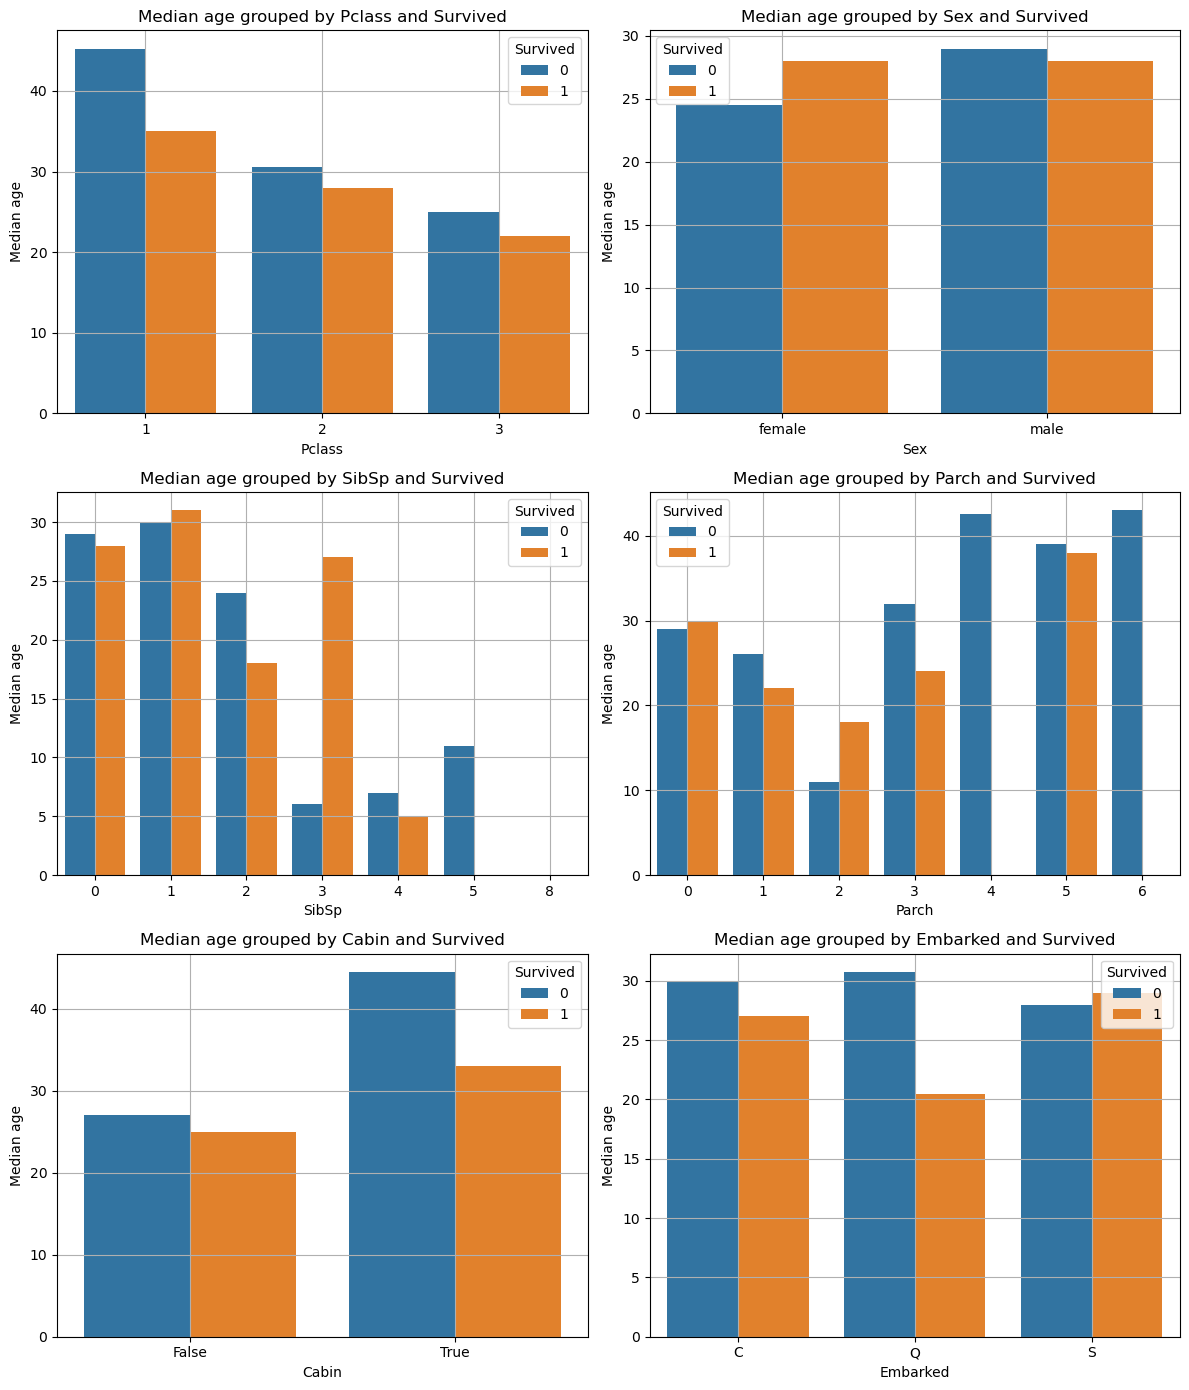

In [20]:
features = list(df.columns) 
features_to_remove = ['Age', 'Fare', 'Survived', 'Name']
features = [x for x in features if x not in features_to_remove]

n_cols = 2  
n_rows = (len(features) // n_cols) + (len(features) % n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 14))
axes = axes.flatten()

for i, feature in enumerate(features):
    median_age = df.groupby([feature, 'Survived'])['Age'].median().reset_index()
    sns.barplot(data=median_age, x=feature, y='Age', hue='Survived', ax=axes[i])

    axes[i].set_title(f'Median age grouped by {feature} and Survived')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Median age')
    axes[i].legend(title='Survived')
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

As we can see, values differ from group to group. For instance, passengers from the 1st class are considerably older than those from the 3rd, died men are slightly older than died women, etc. 

So, it makes sense to perform a group-based median imputation. 

In [21]:
df['Age'] = df.groupby(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch'])['Age'].transform(lambda x: x.fillna(x.median()))
df.isna().sum()

Survived     0
Pclass       0
Name         0
Sex          0
Age         10
SibSp        0
Parch        0
Fare         0
Cabin        0
Embarked     0
dtype: int64

There are still some missing age values for passengers that do not belong to any group. Let us replace them with the median value.

In [22]:
median = df['Age'].median()
df['Age'] = df['Age'].fillna(median)

In [23]:
df.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

# Feature Engineering

I am to create several features:

1. Family_size. It will help identify passengers who travelled alone or with their family regardless of who those relatives exactly were. We already saw on the example of passengers without defined age, that most of them travelled alone and died. Potentially, there can be a similar dependency on the entire dataset, which can improve metrics of our further model.

1. Fare_per_person. It will show us how much a passenger paid for the trip regardless of their family size. This can help us define how rich each passenger was, which must have a correlation with their survival.

2. Age_group. It will split all passengers into several groups based on their age. Theoretically, some age groups can have higher survival rates than the others. For instance, small children can be too helpless and weak to survive, but are more likely to be helped by adults.

3. Title. I am going to extract passengers' titles from Name in hope that they can improve our metrics.

In [24]:
df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_size
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,False,S,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,True,C,2
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,False,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,True,S,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,False,S,1


In [25]:
df.groupby('Family_size')['Survived'].value_counts(normalize=True).apply(lambda x: round(x * 100, 1)).rename('Percentage')

Family_size  Survived
1            0            69.6
             1            30.4
2            1            55.3
             0            44.7
3            1            57.8
             0            42.2
4            1            72.4
             0            27.6
5            0            80.0
             1            20.0
6            0            86.4
             1            13.6
7            0            66.7
             1            33.3
8            0           100.0
11           0           100.0
Name: Percentage, dtype: float64

In [26]:
def new_feature_age_group(df):
    bins = [0, 12, 18, 30, 50, 80]
    labels = [1, 2, 3, 4, 5] # "Child", "Teenager", "Young Adult", "Adult", "Senior" label-encoded 
    df["Age_group"] = pd.cut(df["Age"], bins=bins, labels=labels)

df["Fare_per_person"] = df["Fare"] / df["Family_size"]

# df['Alone'] = (df['Family_size'] == 1).astype(int)

df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.')
df.drop(columns=['Name'], inplace=True)
count_titles = df['Title'].value_counts()
df.loc[df['Title'].isin(count_titles[count_titles < 10].index), 'Title'] = 'Other'

new_feature_age_group(df)

df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_size,Fare_per_person,Title,Age_group
PassengerId,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,False,S,2,3.62500,Mr,3
2,1,1,female,38.0,1,0,71.2833,True,C,2,35.64165,Mrs,4
3,1,3,female,26.0,0,0,7.9250,False,S,1,7.92500,Miss,3
4,1,1,female,35.0,1,0,53.1000,True,S,2,26.55000,Mrs,4
5,0,3,male,35.0,0,0,8.0500,False,S,1,8.05000,Mr,4


# Feature Normalisation and Encoding

There are 6 numerical features in total (including newly created):
Age, Fare, SibSp, Parch, Fare_per_person, Family_size.

Let us build histograms for them.

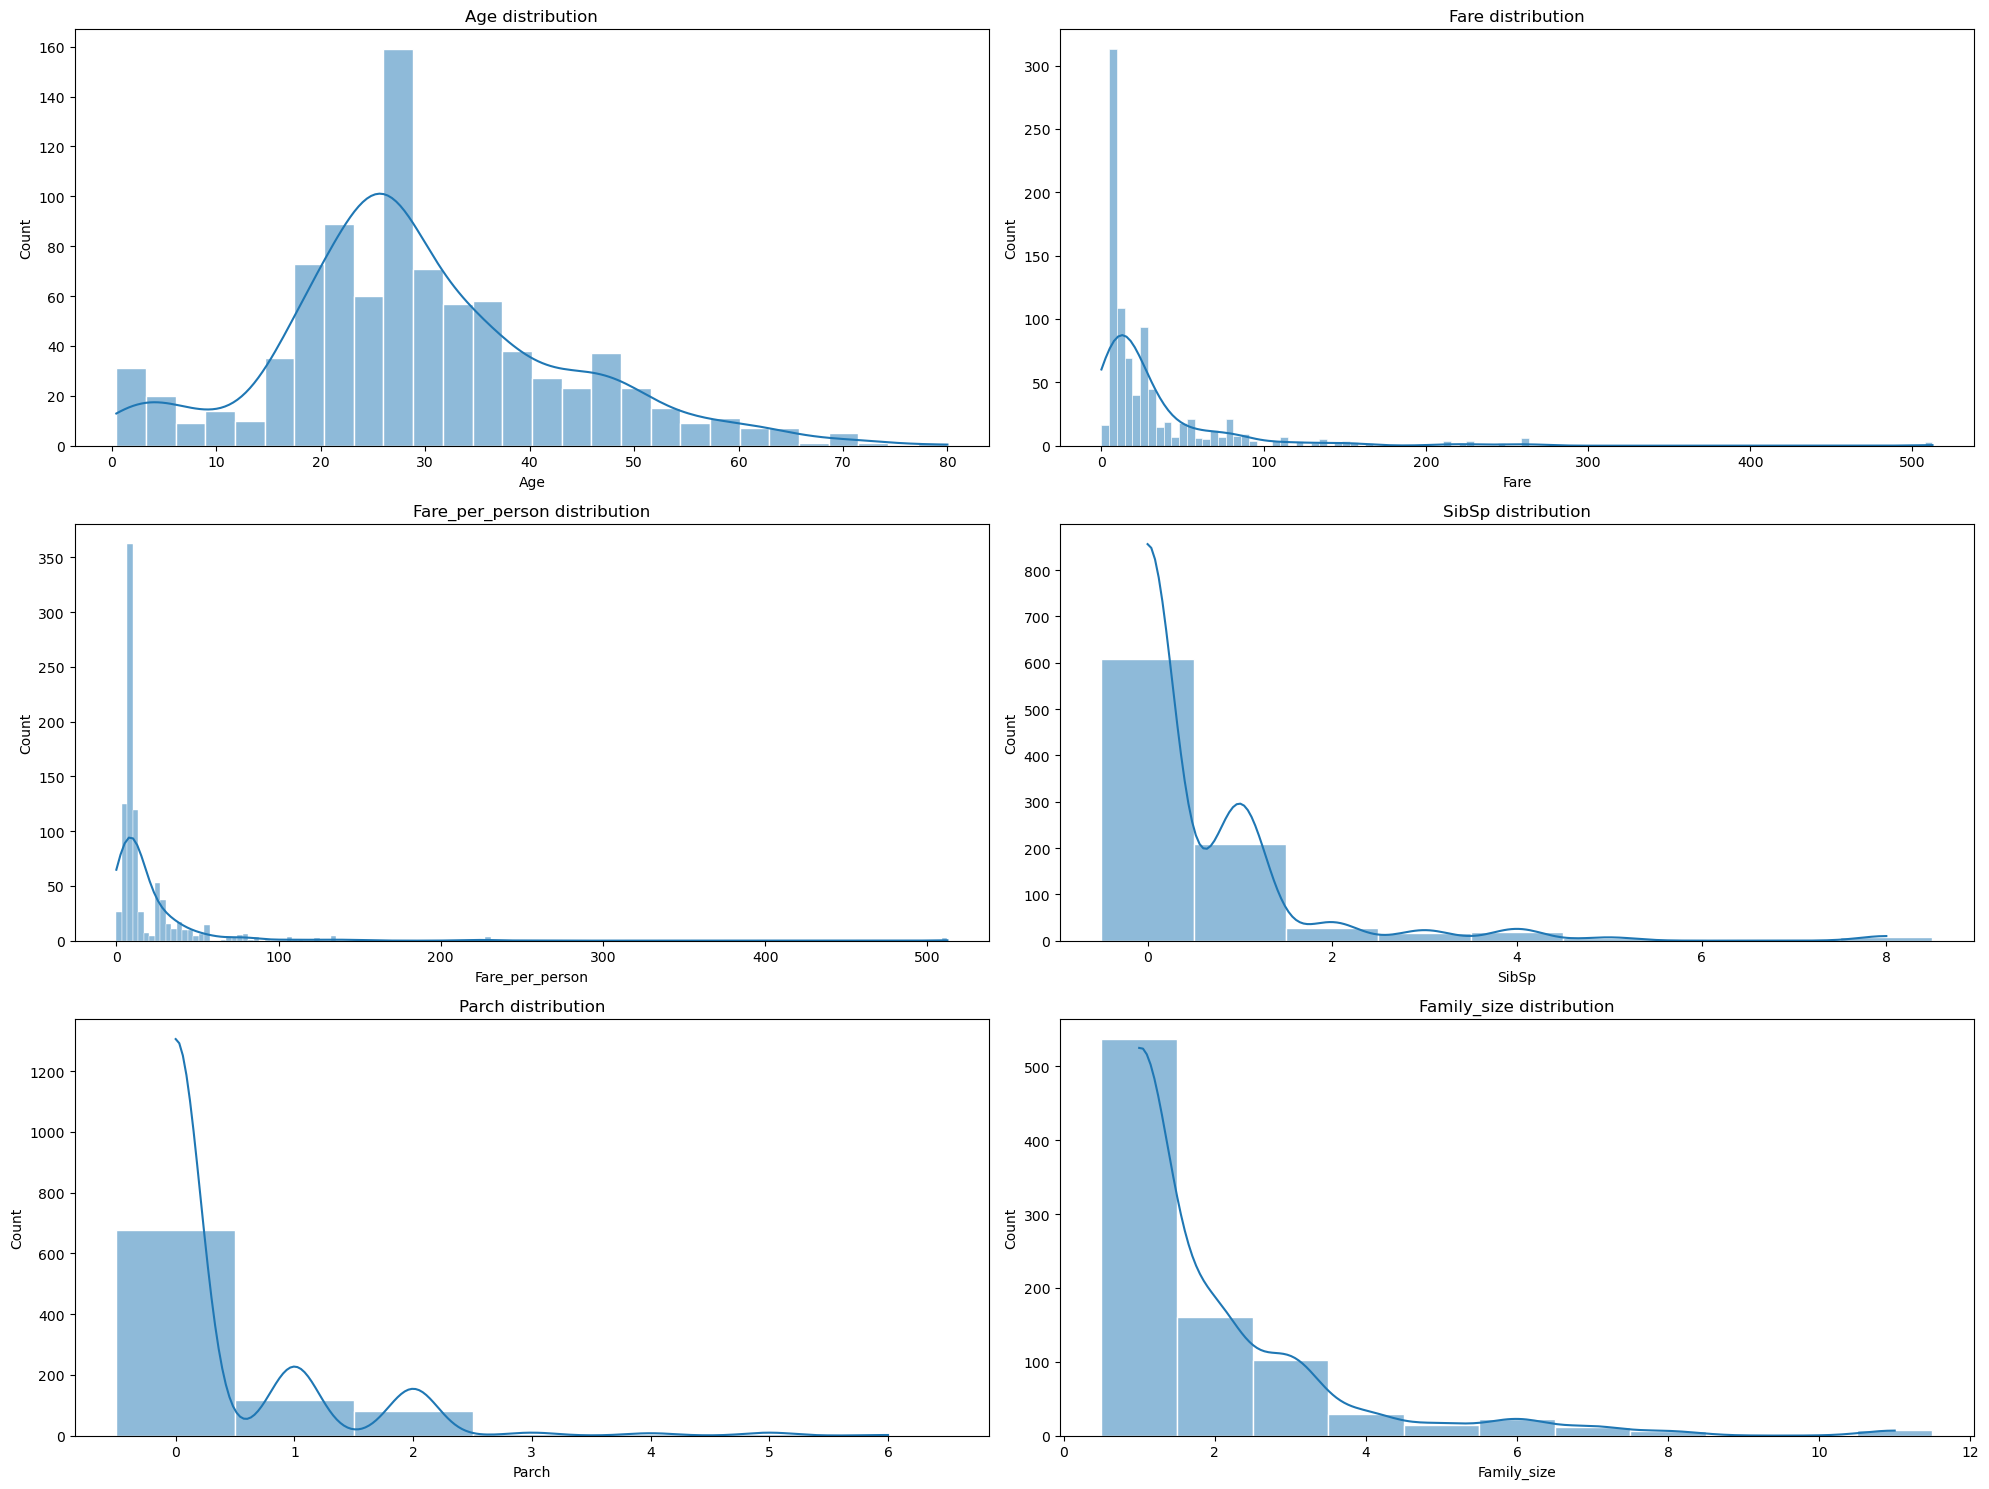

In [27]:
def hist_numerical_features(numerical_features, df):
    ncols = 2
    nrows = len(numerical_features) // ncols
    if len(numerical_features) % ncols != 0:
        nrows += 1
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, feature in enumerate(numerical_features):
        discrete = True if feature in ['SibSp', 'Parch', 'Family_size'] else False
        sns.histplot(data=df[feature].values, fill=True, ax=axes[i], edgecolor='white', kde=True, discrete=discrete)
        
        axes[i].set_title(f'{feature} distribution')
        axes[i].set_xlabel(f'{feature}')
        axes[i].set_ylabel('Count')
    
    # Deleting empty graph
    if len(numerical_features) % ncols != 0:
        fig.delaxes(axes[-1])
            
    plt.tight_layout()
    plt.show()

numerical_features = ['Age', 'Fare', 'Fare_per_person', 'SibSp', 'Parch', 'Family_size']
hist_numerical_features(numerical_features, df)

Obviously, SibSp, Parch, Family_size, Fare and Fare_per_person are similar to each other and have a right-skewed distribution representing the fact that many passengers paid lower fares and travelled alone or with a few relatives.

Age histogram is also slightly skewed to the right showing that most passengers were younger.

It is also worth noticing that absolute values of Fare_per_person, Age and Fare exceed those of SibSp, Family_size and Parch considerably.

Potential issues from the data analytics perspective:

1. Highly skewed distributions can lead to misleading summary statistics. For instance, mean values are not representative in such cases, and median values should be used instead.
2. Outliers can disproportionately influence analyses and visualisations.

Potential problems from the machine learning perspective:

1. Many ML algorithms require normally distributed data as an input. Skewed features can lead to poor performance and low metrics.
2. Features with large ranges (like Fare) may overshadow other features in some algorithms (KNN, SVM, etc).

Let us apply Z-normalisation to tackle these problems.

In [28]:
scaler = StandardScaler()

df_normalised = df.copy()

df_normalised[numerical_features]
df_normalised[numerical_features] = scaler.fit_transform(df_normalised[numerical_features])
df_normalised.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_size,Fare_per_person,Title,Age_group
PassengerId,,,,,,,,,,,,,
1,0,3,male,-0.539071,0.432793,-0.473674,-0.502445,False,S,0.059160,-0.454798,Mr,3
2,1,1,female,0.645301,0.432793,-0.473674,0.786845,True,C,0.059160,0.438994,Mrs,4
3,1,3,female,-0.242978,-0.474545,-0.473674,-0.488854,False,S,-0.560975,-0.334757,Miss,3
4,1,1,female,0.423231,0.432793,-0.473674,0.420730,True,S,0.059160,0.185187,Mrs,4
5,0,3,male,0.423231,-0.474545,-0.473674,-0.486337,False,S,-0.560975,-0.331267,Mr,4


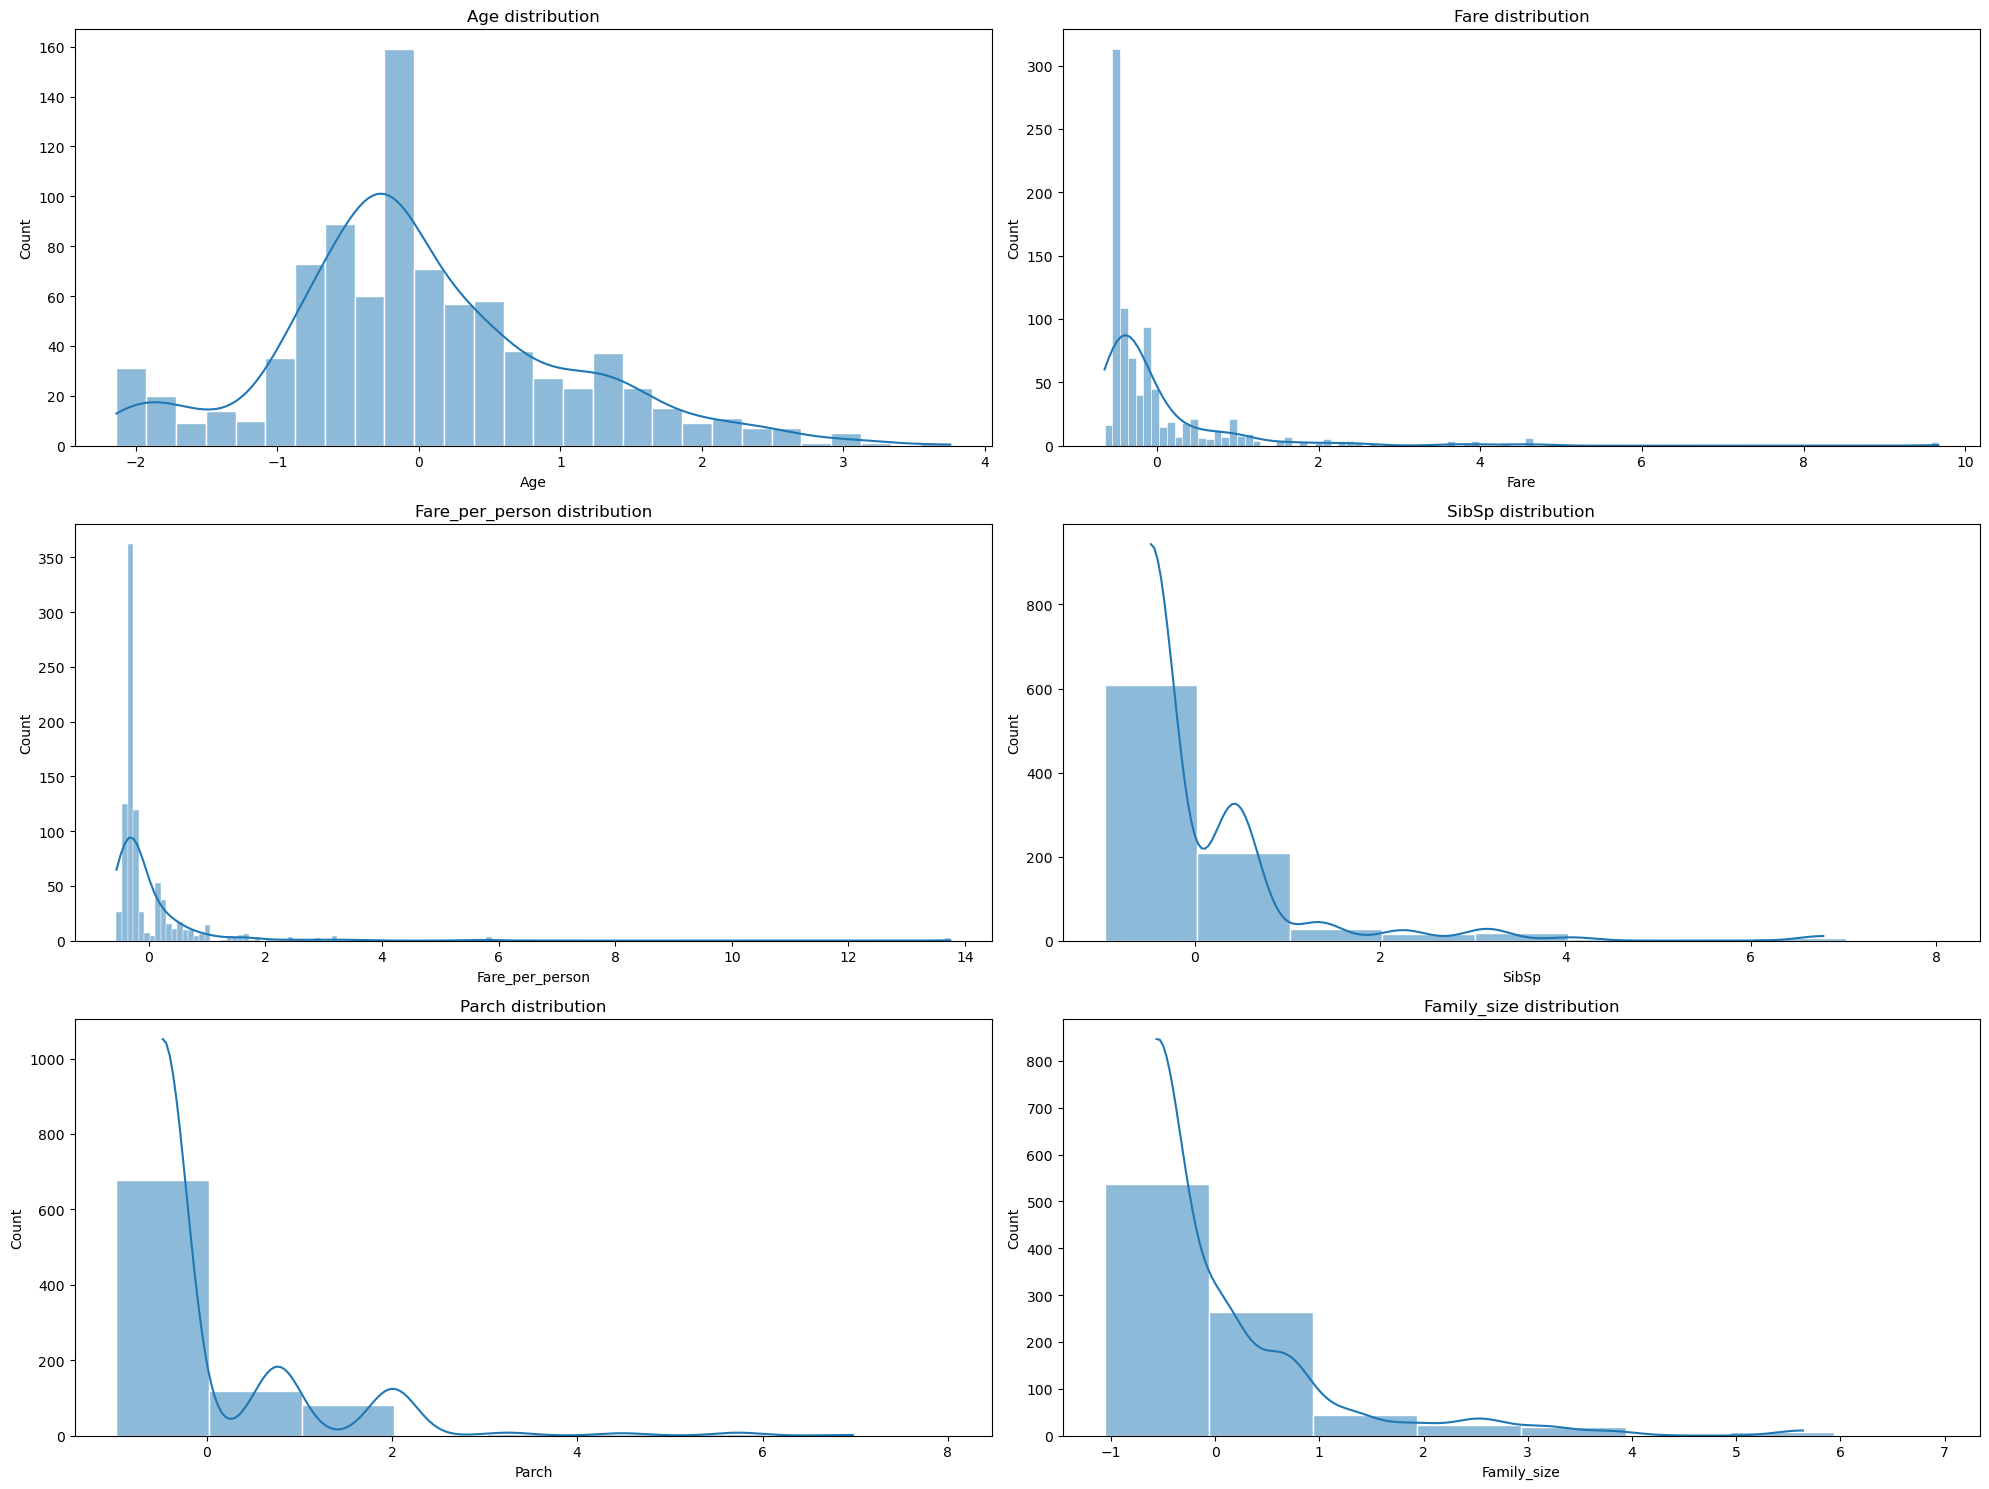

In [29]:
hist_numerical_features(numerical_features, df_normalised)

After applying Z-normalisation, each scaled feature has a mean of 0 and a standard deviation of 1.

There are several categorical features to consider. Among them, only Sex, Title and Embarked contain string values. I am to label-encode them.

In my opinion, it is also a good idea to one-hot encode the Age_group feature, as otherwise its creation does not make much sense.

In [30]:
df_encoded = df_normalised.copy()

label_encoder = LabelEncoder()

df_encoded['Sex'] = label_encoder.fit_transform(df_encoded['Sex'])
df_encoded['Embarked'] = label_encoder.fit_transform(df_encoded['Embarked'])
df_encoded['Title'] = label_encoder.fit_transform(df_encoded['Title'])

df_encoded = pd.get_dummies(df_encoded, columns = ['Age_group'])
df_encoded = df_encoded.replace([True, False], [1, 0])

df_encoded.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_size,Fare_per_person,Title,Age_group_1,Age_group_2,Age_group_3,Age_group_4,Age_group_5
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,1,-0.539071,0.432793,-0.473674,-0.502445,0,2,0.059160,-0.454798,2,0,0,1,0,0
2,1,1,0,0.645301,0.432793,-0.473674,0.786845,1,0,0.059160,0.438994,3,0,0,0,1,0
3,1,3,0,-0.242978,-0.474545,-0.473674,-0.488854,0,2,-0.560975,-0.334757,1,0,0,1,0,0
4,1,1,0,0.423231,0.432793,-0.473674,0.420730,1,2,0.059160,0.185187,3,0,0,0,1,0
5,0,3,1,0.423231,-0.474545,-0.473674,-0.486337,0,2,-0.560975,-0.331267,2,0,0,0,1,0


In [31]:
df_encoded.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_size,Fare_per_person,Title,Age_group_1,Age_group_2,Age_group_3,Age_group_4,Age_group_5
count,891.000000,891.000000,891.000000,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000,891.000000,8.910000e+02,8.910000e+02,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,1.196200e-16,4.386066e-17,5.382900e-17,3.987333e-18,0.228956,1.536476,-2.392400e-17,-2.990500e-17,1.906846,0.084175,0.079686,0.455668,0.308642,0.071829
std,0.486592,0.836071,0.477990,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,0.420397,0.791503,1.000562e+00,1.000562e+00,0.798361,0.277806,0.270958,0.498310,0.462192,0.258350
min,0.000000,1.000000,0.000000,-2.136493e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01,0.000000,0.000000,-5.609748e-01,-5.559950e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,-5.390713e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01,0.000000,1.000000,-5.609748e-01,-3.536006e-01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,-1.689550e-01,-4.745452e-01,-4.736736e-01,-3.573909e-01,0.000000,2.000000,-5.609748e-01,-3.242883e-01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,4.972543e-01,4.327934e-01,-4.736736e-01,-2.424635e-02,0.000000,2.000000,5.915988e-02,1.046949e-01,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,3.000000,1.000000,3.754278e+00,6.784163e+00,6.974147e+00,9.667167e+00,1.000000,2.000000,5.640372e+00,1.374643e+01,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Machine Learning

In [32]:
# Train dataset
df_encoded.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_size,Fare_per_person,Title,Age_group_1,Age_group_2,Age_group_3,Age_group_4,Age_group_5
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,1,-0.539071,0.432793,-0.473674,-0.502445,0,2,0.059160,-0.454798,2,0,0,1,0,0
2,1,1,0,0.645301,0.432793,-0.473674,0.786845,1,0,0.059160,0.438994,3,0,0,0,1,0
3,1,3,0,-0.242978,-0.474545,-0.473674,-0.488854,0,2,-0.560975,-0.334757,1,0,0,1,0,0
4,1,1,0,0.423231,0.432793,-0.473674,0.420730,1,2,0.059160,0.185187,3,0,0,0,1,0
5,0,3,1,0.423231,-0.474545,-0.473674,-0.486337,0,2,-0.560975,-0.331267,2,0,0,0,1,0


In [33]:
df_encoded['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

The dataset is not heavily imbalanced, so apparently there is no need to apply any balancing algorithms so far.

In [34]:
# Preparing train arrays
X_train = np.array(df_encoded.drop(columns='Survived'))
print(f'X_train shape: {X_train.shape}')
y_train = np.array(df_encoded['Survived'])
print(f'y_train shape: {y_train.shape}')

X_train shape: (891, 16)
y_train shape: (891,)


I am going to iterate through some parameters of several algorithms with cross-validation and see which one performs better.

In [35]:
models_with_params = {'KNN': {'model': KNeighborsClassifier,
                              'params': {'n_neighbors': np.array(np.linspace(1, 30, 30)).astype(int), 
                                         'weights': ['uniform', 'distance'],
                                         'metric': ['euclidean', 'manhattan', 'minkowski']}},
    
                      'RandomForest': {'model': RandomForestClassifier,
                                       'params': {'n_estimators': [100, 200],
                                                  'max_depth': [10, None],
                                                  'min_samples_split': [2, 5],
                                                  'min_samples_leaf': [1, 2, 4],
                                                  'max_features': ['sqrt', 'log2']}},
                      'SVM': {'model': SVC,
                              'params': {'C': [0.1, 1, 10],
                                         'kernel': ['linear', 'rbf', 'poly']}},
                      
                      'GradientBoosting': {'model': GradientBoostingClassifier,
                                           'params': {'n_estimators': [100, 200],
                                                      'learning_rate': [0.01, 0.1, 0.2],
                                                      'max_depth': [3, 5, 10]}}}

In [36]:
def fit_predict_CV(results: pd.DataFrame, models_with_params: dict, X_train: np.array, y_train: np.array):
    for i, current_model in enumerate(models_with_params):
        gs = GridSearchCV(models_with_params[current_model]['model'](), models_with_params[current_model]['params'], cv=5, n_jobs=4, verbose=3)
        gs.fit(X_train, y_train)
        single_result = pd.DataFrame(gs.cv_results_)
        single_result['model'] = current_model
        results = pd.concat([results, single_result])
    
    results.reset_index(drop=True, inplace=True)
    results.drop(columns='rank_test_score', inplace=True)
    results.dropna(axis=1, inplace=True)
    return results
    
results = pd.DataFrame()
results = fit_predict_CV(results, models_with_params, X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [37]:
print(f'Maximum accuracy obtained: {results.iloc[results['mean_test_score'].idxmax()]['mean_test_score']}')
print(f'Model: {results.iloc[results['mean_test_score'].idxmax()]['model']}')
print(f'Params: {results.iloc[results['mean_test_score'].idxmax()]['params']}')

Maximum accuracy obtained: 0.8496139602033772
Model: RandomForest
Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [38]:
results.sort_values('mean_test_score', ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,model
189,0.206309,0.001387,0.007877,0.000687,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.843575,0.814607,0.876404,0.825843,0.887640,0.849614,0.028252,RandomForest
186,0.105077,0.001818,0.003998,0.000245,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.837989,0.814607,0.893258,0.814607,0.876404,0.847373,0.032198,RandomForest
191,0.207930,0.004102,0.007793,0.000416,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.832402,0.814607,0.876404,0.814607,0.893258,0.846256,0.032599,RandomForest


Now, it is time to predict values on the test dataset.

In [39]:
# Loading test dataset
df_test = pd.read_csv('dataset\\test.csv', encoding='utf-8', index_col='PassengerId')
df_test_copy = df_test.copy()

# Dropping columns
df_test.drop(columns=['Ticket'], inplace=True)

# Handling NaNs
fare_median = df_test['Fare'].median()
df_test['Fare'].fillna(fare_median, inplace=True)
df_test['Age'] = df_test.groupby(['Pclass', 'Sex', 'SibSp', 'Parch'])['Age'].transform(lambda x: x.fillna(x.median()))
age_median = df_test['Age'].median()
df_test['Age'].fillna(age_median, inplace=True)

# Feature engineering
df_test['Family_size'] = df_test['SibSp'] + df_test['Parch'] + 1
df_test["Fare_per_person"] = df_test["Fare"] / df_test["Family_size"]
# df_test['Alone'] = (df_test['Family_size'] == 1).astype(int)
df_test['Title'] = df_test['Name'].str.extract(' ([A-Za-z]+)\.')
df_test.drop(columns=['Name'], inplace=True)
df_test.loc[df_test['Title'].isin(count_titles[count_titles < 10].index), 'Title'] = 'Other'
new_feature_age_group(df_test)

# Z-normalisation
df_test[numerical_features] = scaler.fit_transform(df_test[numerical_features])

# Label-encoding
df_test['Cabin'] = df_test['Cabin'].notna()
df_test['Sex'] = label_encoder.fit_transform(df_test['Sex'])
df_test['Embarked'] = label_encoder.fit_transform(df_test['Embarked'])
df_test['Title'] = label_encoder.fit_transform(df_test['Title'])

# One-hot encoding
df_test = pd.get_dummies(df_test, columns = ['Age_group'])
df_test = df_test.replace([True, False], [1, 0])
display(df_test.head())

# Preparing test array
X_test = np.array(df_test)
print(f'X_test shape: {X_test.shape}')

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_size,Fare_per_person,Title,Age_group_1,Age_group_2,Age_group_3,Age_group_4,Age_group_5
PassengerId,,,,,,,,,,,,,,,,
892,3,1,0.394513,-0.499470,-0.400248,-0.497413,0,1,-0.553443,-0.392544,3,0,0,0,1,0
893,3,0,1.351973,0.616992,-0.400248,-0.512278,0,2,0.105643,-0.514300,4,0,0,0,1,0
894,2,1,2.500926,-0.499470,-0.400248,-0.464100,0,1,-0.553443,-0.340280,3,0,0,0,0,1
895,3,1,-0.179963,-0.499470,-0.400248,-0.482475,0,2,-0.553443,-0.369108,3,0,0,1,0,0
896,3,0,-0.562947,0.616992,0.619896,-0.417492,0,2,0.764728,-0.497543,4,0,0,1,0,0


X_test shape: (418, 16)


In [40]:
model = models_with_params[results.iloc[results['mean_test_score'].idxmax()]['model']]['model'](**results.iloc[results['mean_test_score'].idxmax()]['params'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred.shape

(418,)

In [41]:
# Preparing a file with results
subm = pd.read_csv(r'dataset\\gender_submission.csv')
subm['Survived'] = y_pred
subm

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [42]:
subm.to_csv('test_subm_proba.csv', index=False)

Submit the file for measurement using the “Submit Predictions” button. The metric used in competitions is accuracy. What was the result? Try to improve it! For example, select the form of features that would be most useful for prediction (feature selection) or create new features (feature generation).

![Titanic_Submission_1](https://raw.githubusercontent.com/Boris-R1/portfolio/main/1_Titanic/Submission_1.JPG)

# Principal Component Analysis

Let us try reducing the number of features using Principal Component Analysis and see how it affects the results.

In [43]:
pca = PCA(n_components=10)
pca.fit(X_train, y_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [44]:
results_pca = pd.DataFrame()
results_pca = fit_predict_CV(results_pca, models_with_params, X_train_pca, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [45]:
print(f'Maximum accuracy obtained: {results_pca.iloc[results_pca['mean_test_score'].idxmax()]['mean_test_score']}')
print(f'Model: {results_pca.iloc[results_pca['mean_test_score'].idxmax()]['model']}')
print(f'Params: {results_pca.iloc[results_pca['mean_test_score'].idxmax()]['params']}')

Maximum accuracy obtained: 0.8451446864603603
Model: RandomForest
Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


In [46]:
model_pca = models_with_params[results_pca.iloc[results_pca['mean_test_score'].idxmax()]['model']]['model'](**results_pca.iloc[results_pca['mean_test_score'].idxmax()]['params'])
model_pca.fit(X_train_pca, y_train)
y_pred = model_pca.predict(X_test_pca)
subm_pca = pd.read_csv(r'dataset\\gender_submission.csv')
subm_pca['Survived'] = y_pred
subm_pca.to_csv('test_subm_proba_PCA.csv', index=False)

![Titanic_Submission_2](https://raw.githubusercontent.com/Boris-R1/portfolio/main/1_Titanic/Submission_2.JPG)

The improvement is unimpressive, but it is better than nothing.

# Summary

The goal of this machine learning task was to develop a predictive model that classifies passengers of Titanic as either survivors (1) or non-survivors (0) based on the given input features. The dataset is located at the link: https://www.kaggle.com/c/titanic/data

Exploratory data analysis revealed key survival trends:

1. Women had a significantly higher survival rate;
2. Higher-class passengers and passengers with more expensive tickets were more likely to survive;
3. Factors such as age and family size also influenced survival chances;
4. etc.

The following new features were extracted from the existing data:

1. Family_size,
2. Fare_per_person,
3. Age_group,
4. Title.

For label classification, I trained multiple models: KNeighborsClassifier, RandomForestClassifier, SVC and GradientBoostingClassifier.
In each algorithm, several parameters were iterated using GridSearchCV.

After dimensionality reduction, RandomForestClassifier provided the best results with the accuracy of 0.77511 on the validation dataset. 

The best params are as follows: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
 
What else can be done for further accuracy improvement:

1. Trying different approaches to filling NaN values,
2. Changing feature encoding,
3. Trying different ML algorithms,
4. Handling overfitting,
5. Extracting more features,
6. Balancing target variable values,
7. etc